In [6]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import random
import tensorflow as tf
import cv2 as cv
import os 
import glob

In [7]:
daisy_dir = glob.glob(os.path.join('daisy/', '*'))
dandelion_dir = glob.glob(os.path.join('dandelion/', '*'))
rose_dir = glob.glob(os.path.join('rose/', '*'))
sunflower_dir = glob.glob(os.path.join('sunflower/', '*'))
tulip_dir = glob.glob(os.path.join('tulip/', '*'))

In [8]:
X_path = daisy_dir + dandelion_dir + rose_dir + sunflower_dir + tulip_dir

X = []

for f in X_path:
    X.append(np.array(cv.resize(cv.imread(f), (224,224), interpolation = cv.INTER_AREA))) 
    
X = np.array(X)

X = X / 255

In [9]:
l_daisy = np.zeros(len(daisy_dir))
l_daisy_string = ['daisy' for i in range(len(daisy_dir))]
l_dandelion = np.ones(len(dandelion_dir))
l_dandelion_string = ['dandelion' for i in range(len(dandelion_dir))]
l_rose = 2*np.ones(len(rose_dir))
l_rose_string = ['rose' for i in range(len(rose_dir))]
l_sunflower = 3*np.ones(len(sunflower_dir))
l_sunflower_string = ['sunflower' for i in range(len(sunflower_dir))]
l_tulip = 4*np.ones(len(tulip_dir))
l_tulip_string = ['tulip' for i in range(len(tulip_dir))]


y_string = np.concatenate((l_daisy_string, l_dandelion_string, l_rose_string, l_sunflower_string, l_tulip_string))
y = np.concatenate((l_daisy, l_dandelion, l_rose, l_sunflower, l_tulip))
y = to_categorical(y, 5)

IndexError: index 0 is out of bounds for axis 0 with size 0

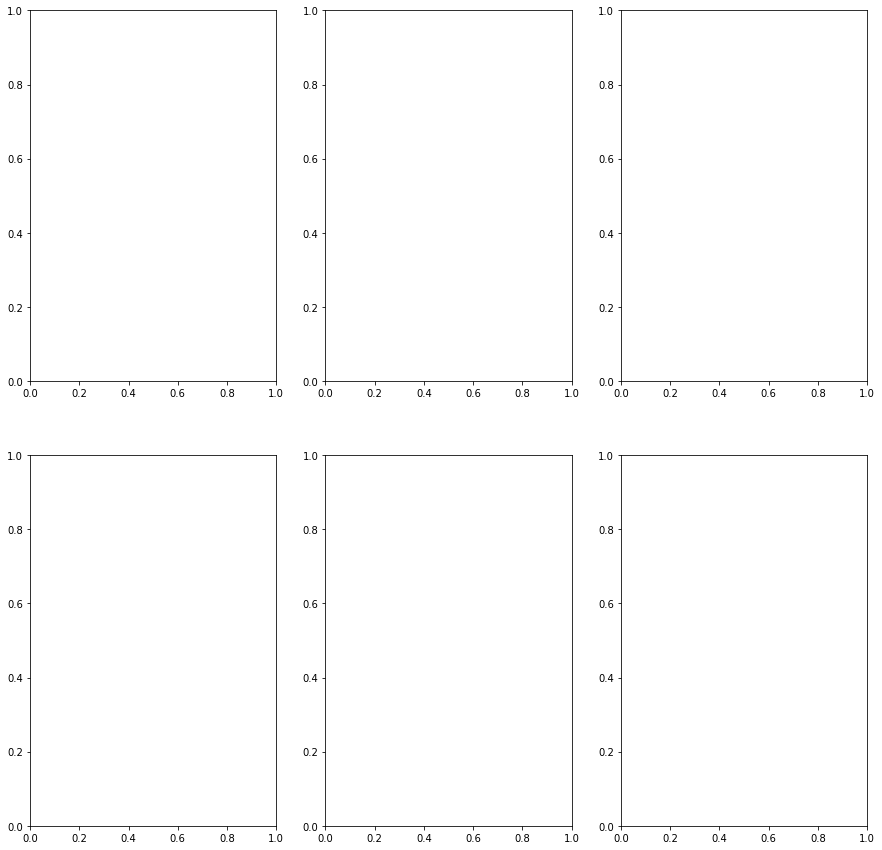

In [10]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (3):
        r = random.randint(0,len(y_string))
        ax[i,j].imshow(X[r][:,:,::-1])
        ax[i,j].set_title('Flower: ' + y_string[r])
        
plt.tight_layout()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X = []

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 15, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True) 

datagen.fit(X_train)

In [ ]:
inp = Input((224,224,3))

conv1 = Conv2D(64, (5,5), padding='valid', activation= 'relu')(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)

conv2 = Conv2D(96, (4,4), padding='valid', activation= 'relu')(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)

conv3 = Conv2D(128, (3,3), padding='valid', activation= 'relu')(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)

conv4 = Conv2D(256, (3,3), padding='valid', activation= 'relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)

flat = Flatten()(conv4)

dense1 = Dense(512, activation= 'relu')(flat)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation= 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)

out = Dense(5, activation = 'softmax')(dense2)

model = Model(inp, out)

model.summary()

In [ ]:
# Other things to the neural net
model.load_weights('my-CNN.32-0.03-0.99-1.33-0.72.hdf5')

nadam = Nadam(lr = 0.0001)

filepath = 'my-CNN.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'

lr_red = keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)

chkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.compile(optimizer = nadam , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 50, initial_epoch = 0, validation_data = (X_val, y_val), callbacks=[lr_red, chkpoint])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
vgg = keras.applications.VGG16(input_shape=(224,224,3), include_top = False, weights= 'imagenet')

x = vgg.output
x = Flatten()(x)
x = Dense(3078,activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x) 
x = Dropout(0.2)(x)
out = Dense(5,activation='softmax')(x) 

tf_model=Model(inputs=vgg.input,outputs=out)

In [ ]:
for i,layer in enumerate(tf_model.layers):
    print(i,layer.name)

In [ ]:
# Bloquando o treinamento das camadas convolucionais
for layer in tf_model.layers[:20]:
    layer.trainable=False

In [ ]:
tf_model.summary()

In [ ]:
tf_model.load_weights('TF-CNN.29-0.08-0.98-1.03-0.85.hdf5')
filepath = 'TF-CNN.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'
lr_red = keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
chkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
tf_model.compile(optimizer = Nadam(0.0001) , loss = 'categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history = tf_model.fit(X_train, y_train, batch_size = 1, epochs = 30, initial_epoch = 0, 
                    validation_data = (X_val, y_val), callbacks=[lr_red, chkpoint])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:

pred = tf_model.predict(X_val)
pred = np.argmax(pred, axis = 1)
pred = pd.DataFrame(pred).replace({0:'daisy',1:'dandelion',2:'rose',3:'sunflower',4:'tulip'})

y_val_string = np.argmax(y_val, axis = 1)
y_val_string = pd.DataFrame(y_val_string).replace({0:'daisy',1:'dandelion',2:'rose',3:'sunflower',4:'tulip'})

In [ ]:
mis_class = []
for i in range(len(y_val_string)):
    if(not y_val_string[0][i] == pred[0][i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
count = 0
fig,ax = plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range (3):
    for j in range (2):
        ax[i,j].imshow(X_val[mis_class[count]][:,:,::-1])
        ax[i,j].set_title("Predicted Flower : "+str(pred[0][mis_class[count]])+"\n"+"Actual Flower : " + str(y_val_string[0][mis_class[count]]))
        plt.tight_layout()
        count+=1